<a href="https://colab.research.google.com/github/TejasviBaddam/Automated-Detection-of-Diabetic-Retinopathy-Using-Convolutional-Neural-Networks-CNN-/blob/main/Data_V1_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import shutil
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from tqdm import tqdm
import cv2
from google.colab import files

In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/binary_dataset"

def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(img_path).resize((224, 224))
            img = np.array(img)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(labels)

healthy_folder = os.path.join(dataset_path, "healthy")
healthy_images, healthy_labels = load_images_from_folder(healthy_folder, label=0)

non_healthy_folder = os.path.join(dataset_path, "non_healthy")
non_healthy_images, non_healthy_labels = load_images_from_folder(non_healthy_folder, label=1)

X = np.concatenate((healthy_images, non_healthy_images), axis=0)
y = np.concatenate((healthy_labels, non_healthy_labels), axis=0)

print(f"Total images loaded: {X.shape[0]}")
print(f"Healthy images: {healthy_images.shape[0]}")
print(f"Non-healthy images: {non_healthy_images.shape[0]}")

Total images loaded: 3662
Healthy images: 1805
Non-healthy images: 1857


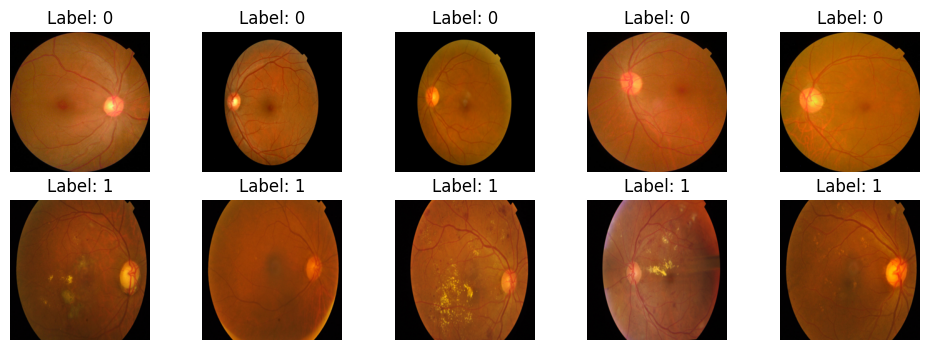

In [ ]:
def show_sample_images(images, labels, num_images_per_label=5):
    unique_labels = np.unique(labels)

    plt.figure(figsize=(12, 2 * len(unique_labels)))

    for label_index, label in enumerate(unique_labels):
        label_indices = np.where(labels == label)[0]
        label_images = images[label_indices]
        label_labels = labels[label_indices]

        for i in range(num_images_per_label):
            plt.subplot(len(unique_labels), num_images_per_label, label_index * num_images_per_label + i + 1)  # Calculate subplot position
            plt.imshow(label_images[i])
            plt.title(f"Label: {label_labels[i]}")
            plt.axis('off')

    plt.show()

show_sample_images(X, y, num_images_per_label=5)

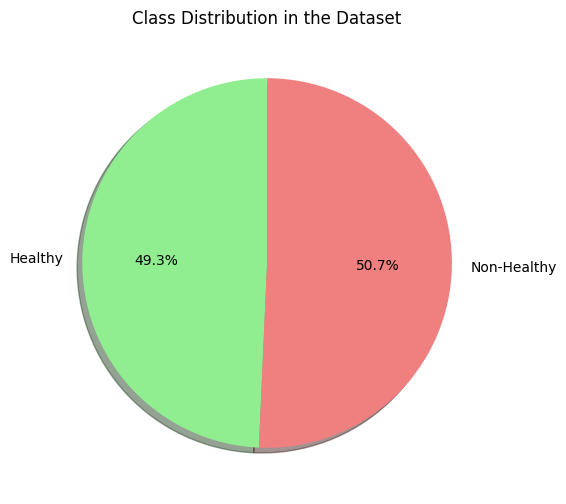

In [ ]:
healthy_count = np.sum(y == 0)
non_healthy_count = np.sum(y == 1)

labels = ['Healthy', 'Non-Healthy']

sizes = [healthy_count, non_healthy_count]

colors = ['lightgreen', 'lightcoral']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Class Distribution in the Dataset')
plt.show()

In [ ]:
def apply_clahe(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    clahe_image = clahe.apply(gray_image)

    clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)

    return clahe_image

X_clahe = np.array([apply_clahe(image) for image in X])

print(f"Shape of CLAHE-processed dataset: {X_clahe.shape}")

Shape of CLAHE-processed dataset: (3662, 224, 224, 3)


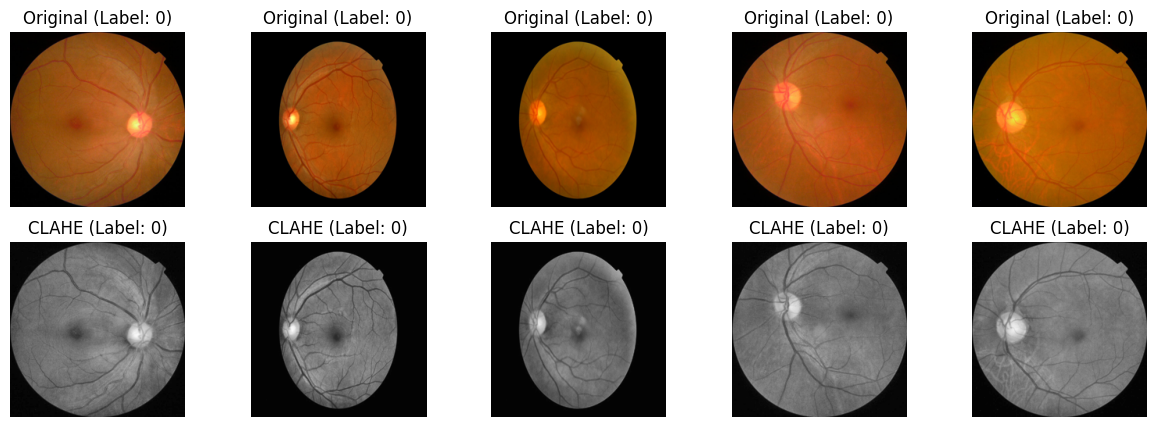

In [ ]:
def show_original_vs_clahe(original_images, clahe_images, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[i])
        plt.title(f"Original (Label: {y[i]})")
        plt.axis('off')

        plt.subplot(2, num_images, i+num_images+1)
        plt.imshow(clahe_images[i])
        plt.title(f"CLAHE (Label: {y[i]})")
        plt.axis('off')
    plt.show()

show_original_vs_clahe(X, X_clahe, num_images=5)

In [ ]:
np.save("/content/drive/MyDrive/dataset/X_clahe.npy", X_clahe)

In [ ]:
X_clahe_normalized = X_clahe / 255.0


# Split the Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clahe_normalized, y, test_size=0.1, random_state=42)

print(f"Training set: {X_train.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

Training set: 3295 images
Testing set: 367 images


#CNN Model

In [ ]:
def build_cnn_model(input_shape=(224, 224, 3)):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

model = build_cnn_model()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 68s 649ms/step - accuracy: 0.7962 - loss: 0.4729 - val_accuracy: 0.9319 - val_loss: 0.2156
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 65s 631ms/step - accuracy: 0.9044 - loss: 0.2385 - val_accuracy: 0.9428 - val_loss: 0.2022
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 66s 639ms/step - accuracy: 0.9157 - loss: 0.2268 - val_accuracy: 0.9455 - val_loss: 0.1988
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 67s 649ms/step - accuracy: 0.9173 - loss: 0.2356 - val_accuracy: 0.9373 - val_loss: 0.1895
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 67s 653ms/step - accuracy: 0.9380 - loss: 0.1977 - val_accuracy: 0.9401 - val_loss: 0.1969
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 89s 862ms/step - accuracy: 0.9432 - loss: 0.1728 - val_accuracy: 0.9346 - val_loss: 0.2193
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 69s 666ms/step - accuracy: 0.9510 - loss: 0.1558 - val_accuracy: 0.9510 - val_loss: 0.1860
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 68s 660ms/step - accuracy: 0.9567 - loss: 0

# Evaluate the model on the test set


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2384
Test Accuracy: 0.9401


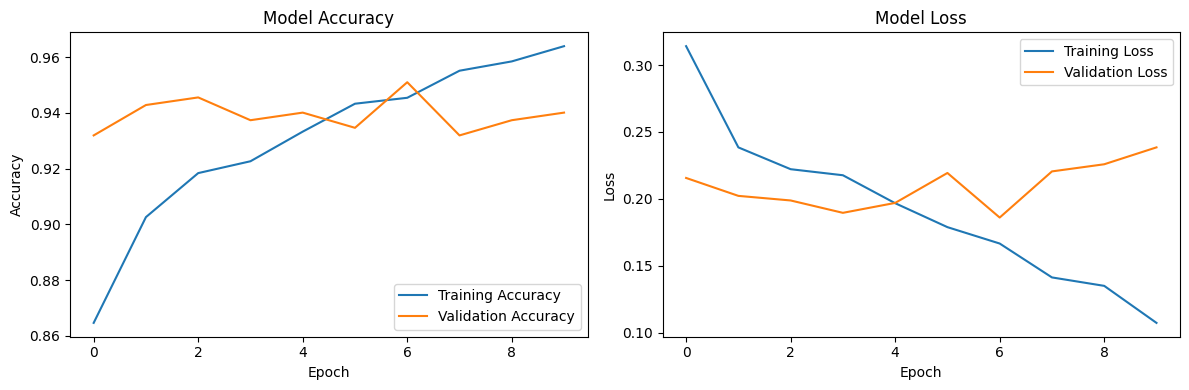

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       188
           1       0.95      0.93      0.94       179

    accuracy                           0.94       367
   macro avg       0.94      0.94      0.94       367
weighted avg       0.94      0.94      0.94       367



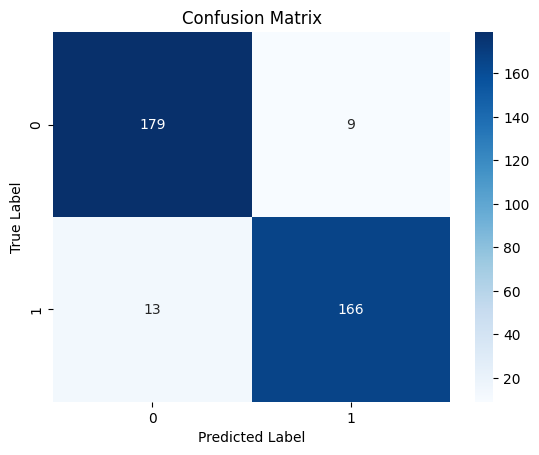

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

history = model.fit(train_generator,
                    epochs=30,
                    validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 71s 684ms/step - accuracy: 0.6384 - loss: 0.8339 - val_accuracy: 0.7847 - val_loss: 0.4334
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 69s 670ms/step - accuracy: 0.8412 - loss: 0.3753 - val_accuracy: 0.9074 - val_loss: 0.2741
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 70s 675ms/step - accuracy: 0.8386 - loss: 0.3474 - val_accuracy: 0.8692 - val_loss: 0.2646
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 69s 671ms/step - accuracy: 0.8692 - loss: 0.3120 - val_accuracy: 0.8747 - val_loss: 0.2745
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 93s 905ms/step - accuracy: 0.8710 - loss: 0.3160 - val_accuracy: 0.8937 - val_loss: 0.2891
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 74s 710ms/step - accuracy: 0.8770 - loss: 0.2981 - val_accuracy: 0.8747 - val_loss: 0.2494
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 70s 680ms/step - accuracy: 0.8770 - loss: 0.2987 - val_accuracy: 0.8774 - val_loss: 0.2799
Epoch 8/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 70s 673ms/step - accuracy: 0.8812 - loss: 0

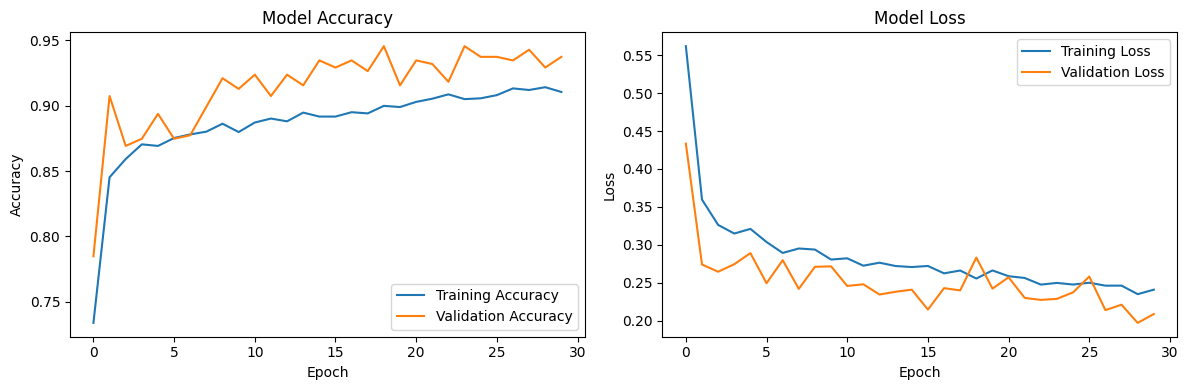

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       188
           1       0.98      0.89      0.93       179

    accuracy                           0.94       367
   macro avg       0.94      0.94      0.94       367
weighted avg       0.94      0.94      0.94       367



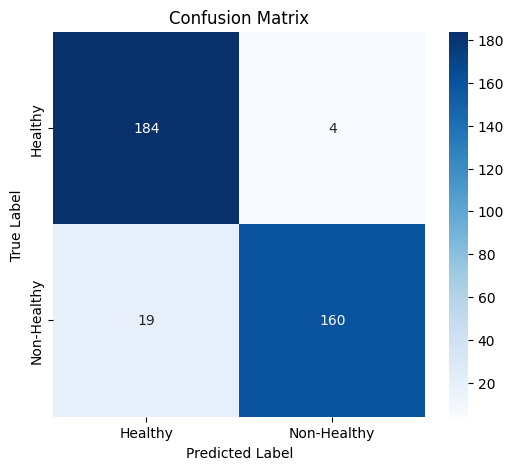

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Non-Healthy'], yticklabels=['Healthy', 'Non-Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Load pre-trained ResNet50 model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5268 - loss: 0.8592 - val_accuracy: 0.6458 - val_loss: 0.6872 - learning_rate: 1.0000e-04
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5091 - loss: 0.7370 - val_accuracy: 0.8093 - val_loss: 0.6753 - learning_rate: 1.0000e-04
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5282 - loss: 0.6974 - val_accuracy: 0.5858 - val_loss: 0.6660 - learning_rate: 1.0000e-04
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5879 - loss: 0.6716 - val_accuracy: 0.5177 - val_loss: 0.6582 - learning_rate: 1.0000e-04
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.5986 - loss: 0.6702 - val_accuracy: 0.5913 - val_loss: 0.6456 - learning_rate: 1.0000e-04
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6302 - loss: 0.6657 - val_accuracy: 0.8828 - val_loss: 0.6319 - learning_rate: 1.0000e-04
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - acc

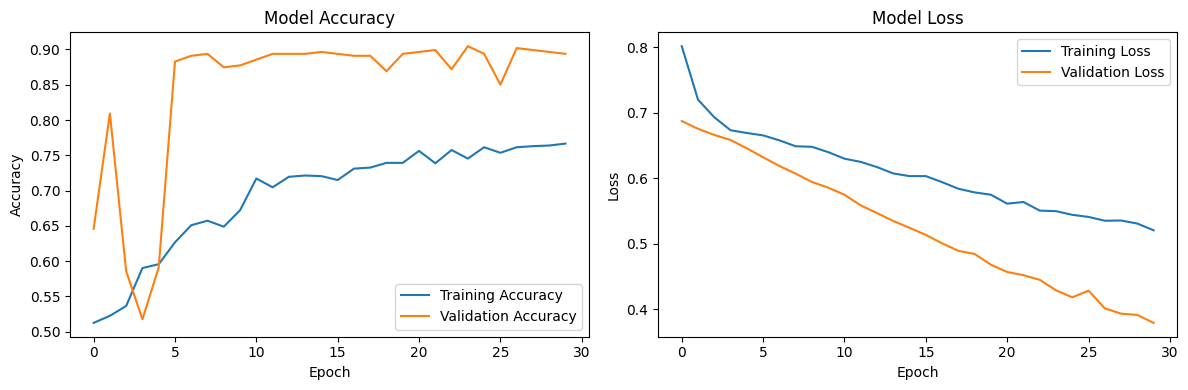

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       188
           1       0.88      0.90      0.89       179

    accuracy                           0.89       367
   macro avg       0.89      0.89      0.89       367
weighted avg       0.89      0.89      0.89       367



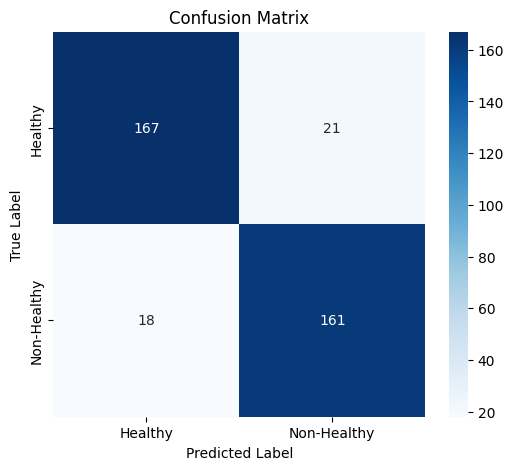

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]
)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Classification Report and Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Non-Healthy'], yticklabels=['Healthy', 'Non-Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Pre-Trained InceptionV3 Model

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 88s 795ms/step - accuracy: 0.6912 - loss: 0.6053 - val_accuracy: 0.8583 - val_loss: 0.3443 - learning_rate: 1.0000e-04
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 78s 752ms/step - accuracy: 0.8695 - loss: 0.3147 - val_accuracy: 0.9101 - val_loss: 0.2209 - learning_rate: 1.0000e-04
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 78s 751ms/step - accuracy: 0.8917 - loss: 0.2813 - val_accuracy: 0.9155 - val_loss: 0.1951 - learning_rate: 1.0000e-04
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 78s 753ms/step - accuracy: 0.8975 - loss: 0.2555 - val_accuracy: 0.9373 - val_loss: 0.1672 - learning_rate: 1.0000e-04
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 78s 752ms/step - accuracy: 0.9023 - loss: 0.2307 - val_accuracy: 0.9101 - val_loss: 0.2039 - learning_rate: 1.0000e-04
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 78s 753ms/step - accuracy: 0.9167 - loss: 0.2116 - val_accuracy: 0.9510 - val_loss: 0.1479 - learning_rate: 1.0000e-04
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 77s 74

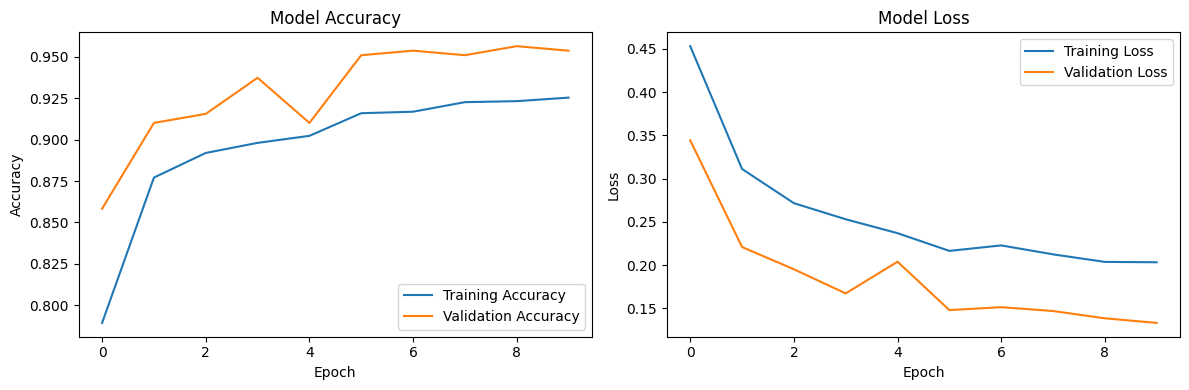

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 772ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       188
           1       0.95      0.96      0.95       179

    accuracy                           0.95       367
   macro avg       0.95      0.95      0.95       367
weighted avg       0.95      0.95      0.95       367



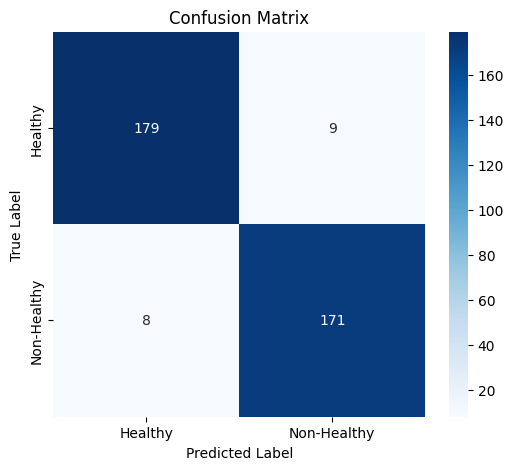

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,  # Use the augmented data generator
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Classification Report and Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Non-Healthy'], yticklabels=['Healthy', 'Non-Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Save the InceptionV3 model
model.save("/content/drive/MyDrive/dataset/best_model_inceptionv3.keras")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("/content/drive/MyDrive/dataset/best_model_inceptionv3.keras")
print("Model loaded successfully!")

# Evaluate the loaded model (optional)
loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=0)
print(f"Loaded Model Test Loss: {loss:.4f}")
print(f"Loaded Model Test Accuracy: {accuracy:.4f}")

Model loaded successfully!
Loaded Model Test Loss: 0.1331
Loaded Model Test Accuracy: 0.9537


In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/dataset/best_model_inceptionv3.keras")

# Paths
test_folder = "/content/drive/MyDrive/dataset/test_images"
test_csv = "/content/drive/MyDrive/dataset/test.csv"

# Load the test CSV file
test_df = pd.read_csv(test_csv)

# Function to preprocess a single image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to make predictions
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Non-Healthy (DR Detected)"
    else:
        return "Healthy (No DR)"

# Predict on all test images and save results
results = []
for idx, row in test_df.iterrows():
    img_name = row["id_code"] + ".png"  # Assuming images are in PNG format
    img_path = os.path.join(test_folder, img_name)
    if os.path.exists(img_path):
        result = predict_image(img_path)
        results.append((img_name, result))
    else:
        results.append((img_name, "Image Not Found"))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=["id_code", "prediction"])

# Save results to a CSV file
results_df.to_csv("/content/drive/MyDrive/dataset/test_predictions.csv", index=False)
print("Predictions saved successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━

Saving 0fffa73e2402.png to 0fffa73e2402.png
Uploaded image: 0fffa73e2402.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_6']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


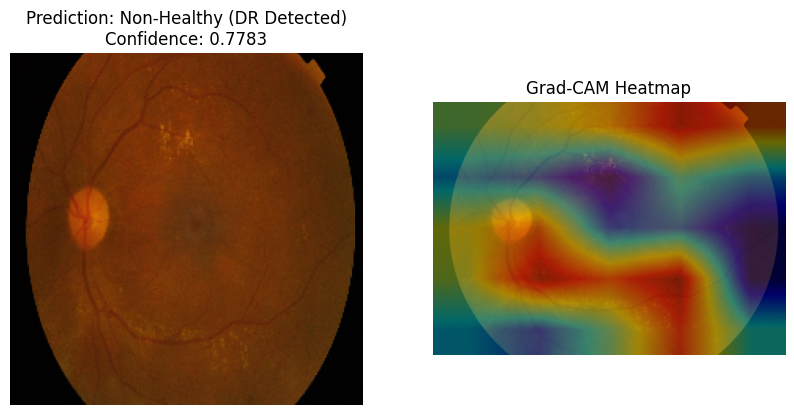

In [25]:
uploaded = files.upload()

image_name = list(uploaded.keys())[0]
print(f"Uploaded image: {image_name}")

model = load_model("/content/drive/MyDrive/dataset/best_model_inceptionv3.h5")

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    confidence = prediction[0][0]
    if confidence > 0.5:
        result = "Non-Healthy (DR Detected)"
    else:
        result = "Healthy (No DR)"
    return result, confidence, img_array

def grad_cam(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return superimposed_img

result, confidence, img_array = predict_image(image_name)

img = image.load_img(image_name, target_size=(224, 224))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {result}\nConfidence: {confidence:.4f}")

last_conv_layer_name = "mixed10"
heatmap = grad_cam(img_array, model, last_conv_layer_name)
superimposed_img = overlay_heatmap(image_name, heatmap)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.show()